# Adaptive RAG
Adaptive RAG는 질문의 특성과 복잡도에 따라 **적응적으로** 다른 검색 전략을 사용하는 고급 RAG 기법입니다.


## 주요 개념

1. **질문 분류**: 질문의 복잡도와 유형을 분석
2. **동적 라우팅**: 질문 유형에 따라 적절한 retrieval 전략 선택
3. **Multi-Query Retrieval**: 복잡한 질문을 여러 하위 질문으로 분해하여 검색
4. **신뢰도 기반 응답**: 검색 결과의 신뢰도에 따라 답변 생성

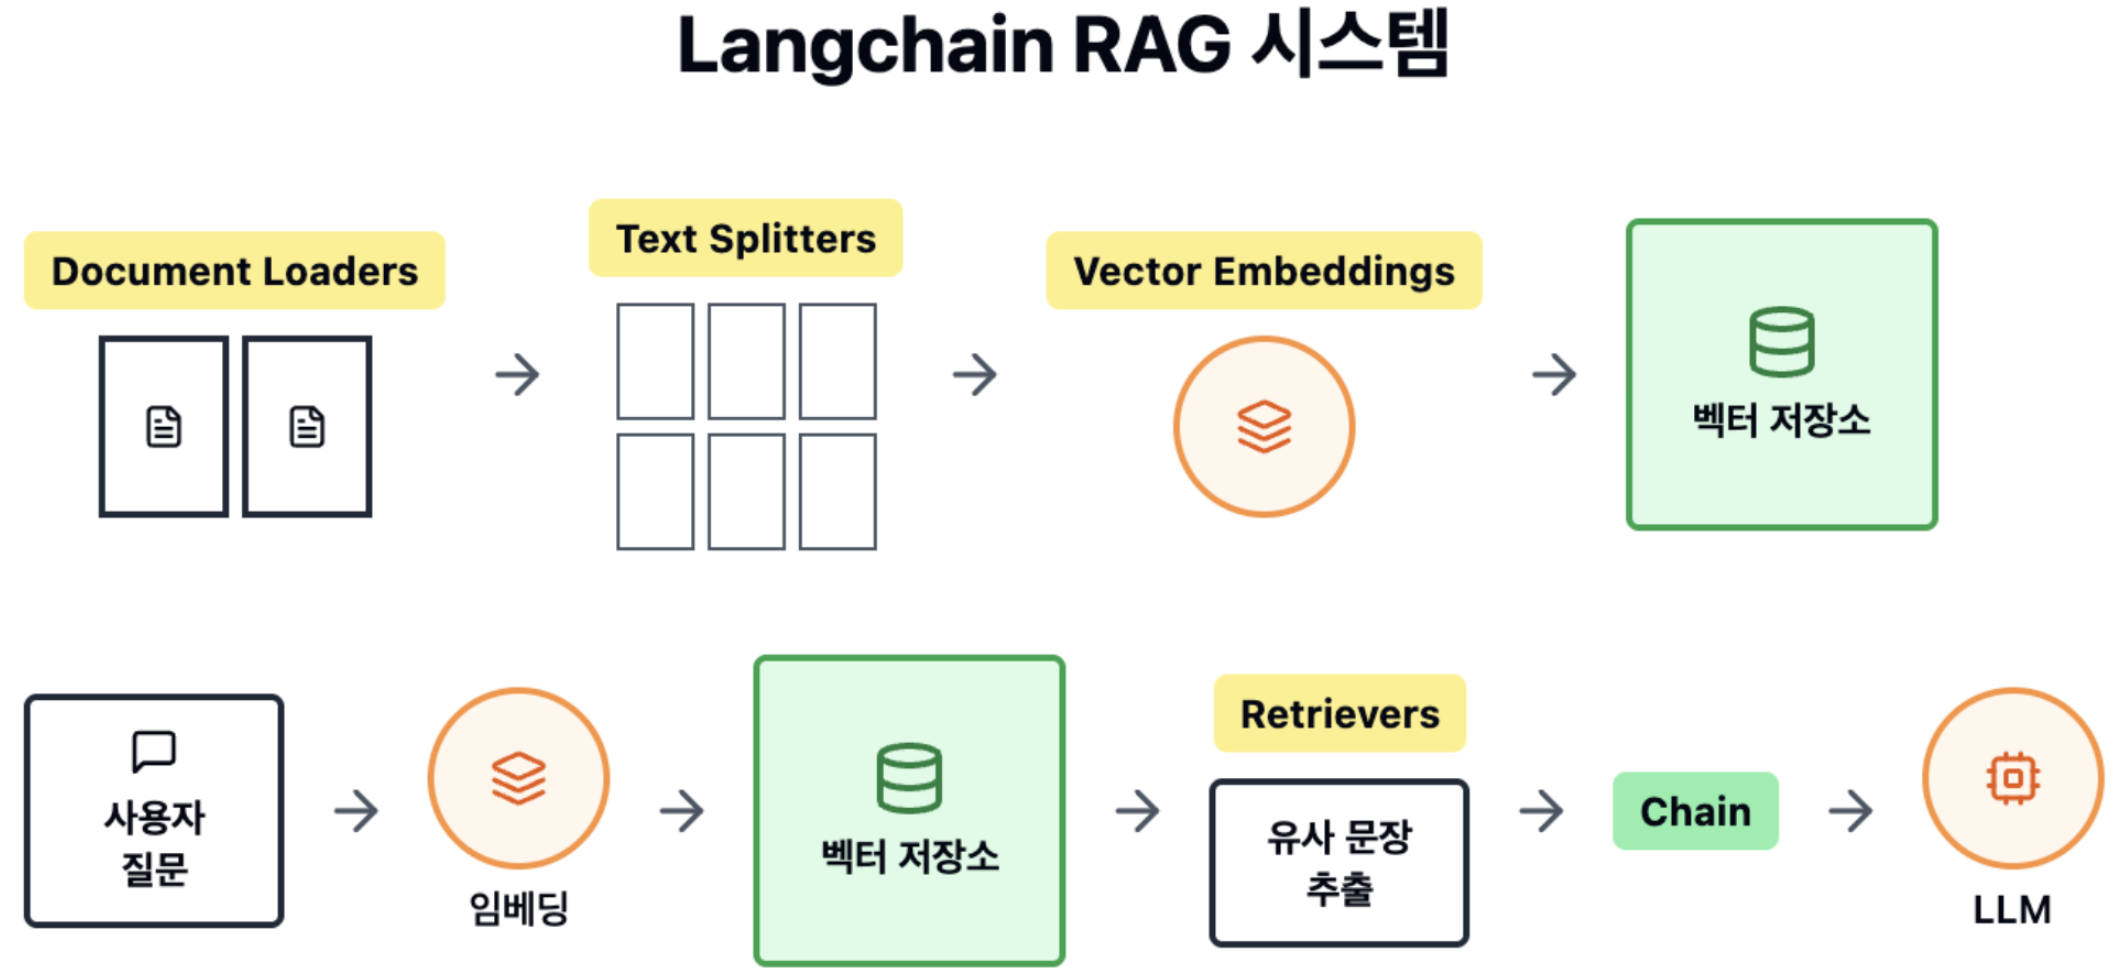

## 1. 환경 설정


In [1]:
# 필요한 라이브러리 임포트
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.documents import Document
from typing import List
import logging


### OpenAI Key 등록
- [OpenAI Key 발급](https://platform.openai.com/api-keys)
- [OpenAI 요금](https://openai.com/api/pricing/)

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'sk-proj-yourkeyhere'


## 2. 데이터 로드 및 벡터 스토어 구축


### TextLoader

In [3]:
from langchain_community.document_loaders import TextLoader

DATA_PATH = "./data/"
loader = TextLoader(DATA_PATH+"rag-keywords.txt")

# 전체 파일 로드
raw_documents = loader.load()

# 각 키워드를 개별 Document로 분할하고 제목을 메타데이터에 추가
documents = []
content = raw_documents[0].page_content
entries = content.strip().split("\n\n")

for entry in entries:
    if entry.strip():
        lines = entry.strip().split("\n")
        if lines:
            # 첫 줄을 제목으로 사용
            title = lines[0]
            content_text = "\n".join(lines)
            
            documents.append(
                Document(
                    page_content=content_text,
                    metadata={"title": title, "source": "rag-keywords.txt"}
                )
            )

print(f"총 {len(documents)}개의 문서를 로드했습니다.")
print(f"\n첫 번째 문서 예시:")
print(f"제목: {documents[0].metadata['title']}")
print(f"내용: {documents[0].page_content[:150]}...")


총 59개의 문서를 로드했습니다.

첫 번째 문서 예시:
제목: Semantic Search
내용: Semantic Search...


### 임베딩 모델

In [4]:
# 임베딩 모델 초기화
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")


### 벡터 스토어 생성

In [5]:
# ChromaDB 벡터 스토어 생성
vectorstore = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    collection_name="rag_keywords",
    persist_directory="./chroma_db"
)

print("ChromaDB 벡터 스토어 생성 완료!")


ChromaDB 벡터 스토어 생성 완료!


## 3. 질문 분류기 구현

질문의 복잡도를 분석하여 적절한 retrieval 전략을 선택합니다.


### LLM 초기화

In [6]:
# LLM 초기화
llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")


### 질문 분류 프롬프트

In [7]:
# 질문 분류 프롬프트
classification_prompt = ChatPromptTemplate.from_messages([
    ("system", 
    """
        당신은 질문을 분석하는 전문가입니다. 
        주어진 질문을 분석하여 다음 중 하나로 분류하세요:

        1. SIMPLE: 단순하고 직접적인 질문 (예: "임베딩이란?", "Token의 정의는?")
        2. COMPLEX: 복잡하거나 다면적인 질문 (예: "임베딩과 벡터스토어의 관계는?", "RAG 시스템의 전체 구조를 설명해줘")
        3. OUT_OF_SCOPE: RAG, NLP, AI, 데이터 관련이 아닌 질문

        반드시 SIMPLE, COMPLEX, OUT_OF_SCOPE 중 하나만 출력하세요."""),
    ("human", "{question}")
])


### 질문 분류 체인

In [8]:
# 질문 분류 체인
classification_chain = classification_prompt | llm | StrOutputParser()


### 테스트

In [9]:
# 테스트
test_questions = [
    "임베딩이란 무엇인가요?",
    "Semantic Search와 Keyword Search의 차이점과 각각의 장단점을 비교해주세요",
    "오늘 저녁 메뉴 추천해줘"
]

print("=== 질문 분류 테스트 ===\n")
for q in test_questions:
    category = classification_chain.invoke({"question": q})
    print(f"질문: {q}")
    print(f"분류: {category}\n")


=== 질문 분류 테스트 ===

질문: 임베딩이란 무엇인가요?
분류: SIMPLE

질문: Semantic Search와 Keyword Search의 차이점과 각각의 장단점을 비교해주세요
분류: COMPLEX

질문: 오늘 저녁 메뉴 추천해줘
분류: OUT_OF_SCOPE



## 4. MultiQueryRetriever 설정

복잡한 질문을 여러 개의 하위 질문으로 분해하여 더 포괄적인 검색을 수행합니다.


### 기본 retriever 생성

In [10]:
# 기본 retriever 생성
base_retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3}
)


### MultiQueryRetriever 생성

In [11]:
# MultiQueryRetriever 생성
multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=base_retriever,
    llm=llm
)


### MultiQueryRetriever 테스트

In [12]:
# MultiQueryRetriever 테스트
test_query = "Semantic Search와 Keyword Search의 차이는?"
print(f"질문: {test_query}\n")
print("=" * 50)
print("MultiQueryRetriever가 생성한 질문들은 위 로그에서 확인할 수 있습니다.")
print("=" * 50)

results = multi_query_retriever.invoke(test_query)
print(f"\n검색된 문서 수: {len(results)}")
for i, doc in enumerate(results, 1):
    print(f"\n[문서 {i}] {doc.metadata.get('title', 'Unknown')}")
    print(f"{doc.page_content[:150]}...")


질문: Semantic Search와 Keyword Search의 차이는?

MultiQueryRetriever가 생성한 질문들은 위 로그에서 확인할 수 있습니다.

검색된 문서 수: 4

[문서 1] Semantic Search
Semantic Search...

[문서 2] Keyword Search
Keyword Search...

[문서 3] 정의: 키워드 검색은 사용자가 입력한 키워드를 기반으로 정보를 찾는 과정입니다. 이는 대부분의 검색 엔진과 데이터베이스 시스템에서 기본적인 검색 방식으로 사용됩니다.
정의: 키워드 검색은 사용자가 입력한 키워드를 기반으로 정보를 찾는 과정입니다. 이는 대부분의 검색 엔진과 데이터베이스 시스템에서 기본적인 검색 방식으로 사용됩니다.
예시: 사용자가 "커피숍 서울"이라고 검색하면, 관련된 커피숍 목록을 반환합니다.
연관키워드: 검색 엔...

[문서 4] 정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.
정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.
예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.
연관키워드: 자연어 처...


## 5. Adaptive RAG 체인 구현

LCEL을 사용하여 질문 유형에 따라 적응적으로 동작하는 RAG 체인을 구현합니다.


### 적응적 retriever 함수

In [13]:
# 적응적 retriever 함수
def adaptive_retriever(input_dict):
    """질문 유형에 따라 적절한 retriever를 선택"""
    question = input_dict["question"]
    category = input_dict["category"]
    
    print(f"\n[Adaptive RAG] 질문 분류: {category}")
    
    if category == "OUT_OF_SCOPE":
        # 범위 밖 질문은 빈 문서 반환
        return []
    elif category == "SIMPLE":
        # 단순 질문은 기본 retriever 사용
        print("[Adaptive RAG] 전략: 기본 검색")
        return base_retriever.invoke(question)
    else:  # COMPLEX
        # 복잡한 질문은 MultiQueryRetriever 사용
        print("[Adaptive RAG] 전략: 다중 쿼리 검색")
        return multi_query_retriever.invoke(question)


### 문서 포맷팅 함수 (출처 포함)

In [14]:
# 문서 포맷팅 함수 (출처 포함)
def format_docs(docs):
    """검색된 문서를 포맷팅하고 출처 정보 추가"""
    if not docs:
        return "관련 문서를 찾을 수 없습니다.", []
    
    formatted_texts = []
    sources = []
    
    for i, doc in enumerate(docs, 1):
        title = doc.metadata.get("title", "Unknown")
        source = doc.metadata.get("source", "Unknown")
        formatted_texts.append(f"[문서 {i}: {title}]\n{doc.page_content}")
        sources.append(source)
    
    return "\n\n".join(formatted_texts), list(set(sources))  # 중복 제거


### RAG 프롬프트

In [15]:
# RAG 프롬프트
rag_prompt = ChatPromptTemplate.from_messages([
    ("system", 
    """
        당신은 RAG, NLP, AI 관련 질문에 답변하는 전문 어시스턴트입니다.

        다음 규칙을 따르세요:
        1. 제공된 컨텍스트만을 기반으로 답변하세요.
        2. 컨텍스트에 관련 정보가 없으면 "죄송하지만, 제공된 정보에서는 해당 질문에 대한 답을 찾을 수 없습니다."라고 답변하세요.
        3. 답변은 명확하고 간결하게 작성하세요.
        4. 예시가 있다면 함께 설명해주세요.

        컨텍스트:
        {context}"""),
    ("human", "{question}")
])


### 답변에 출처 추가 함수

In [16]:
# 답변에 출처 추가 함수
def add_sources(response_dict):
    """답변에 출처 정보 추가"""
    answer = response_dict["answer"]
    sources = response_dict["sources"]
    
    # 출처가 없거나, Unknown만 있거나, 답변이 "찾을 수 없습니다"를 포함하면 출처 추가 안함
    if not sources or sources == ["Unknown"] or "찾을 수 없습니다" in answer:
        return answer
    
    # Unknown을 제외한 실제 출처만 필터링
    valid_sources = [s for s in sources if s != "Unknown"]
    if not valid_sources:
        return answer
    
    source_text = "\n\n---\n**출처:**\n" + "\n".join([f"- {source}" for source in valid_sources])
    return answer + source_text

print("Adaptive RAG 함수 정의 완료!")


Adaptive RAG 함수 정의 완료!


### LCEL을 사용한 Adaptive RAG 체인 구성

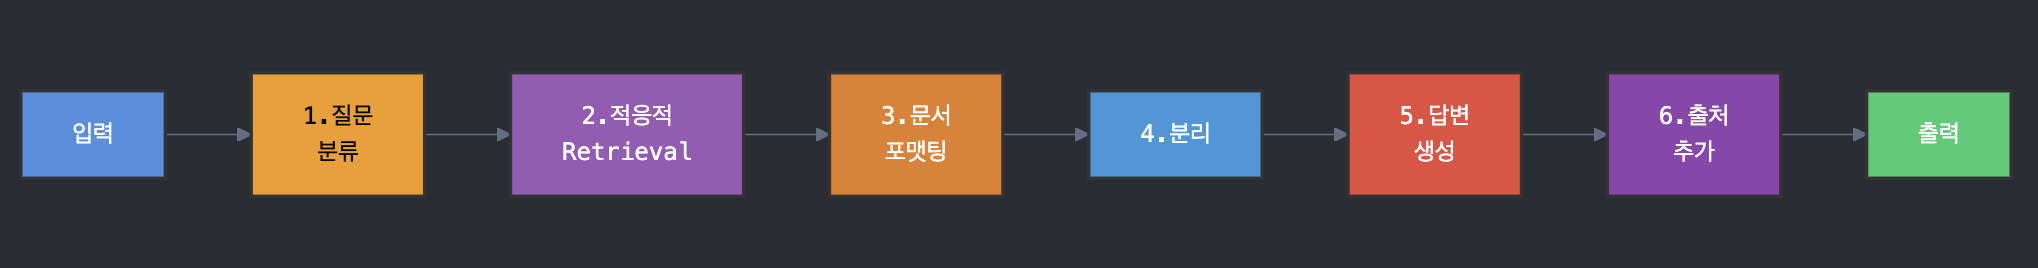

In [17]:
# LCEL을 사용한 Adaptive RAG 체인 구성
adaptive_rag_chain = (
    # 1단계: 질문 분류
    {
        "question": RunnablePassthrough(),
        "category": classification_chain
    }
    # 2단계: 적응적 retrieval
    | RunnablePassthrough.assign(
        docs=RunnableLambda(adaptive_retriever)
    )
    # 3단계: 문서 포맷팅 및 출처 추출
    | RunnablePassthrough.assign(
        formatted=lambda x: format_docs(x["docs"])
    )
    # 4단계: context와 sources 분리
    | RunnablePassthrough.assign(
        context=lambda x: x["formatted"][0],
        sources=lambda x: x["formatted"][1]
    )
    # 5단계: RAG 답변 생성
    | RunnablePassthrough.assign(
        answer=(
            {
                "context": lambda x: x["context"],
                "question": lambda x: x["question"]
            }
            | rag_prompt
            | llm
            | StrOutputParser()
        )
    )
    # 6단계: 출처 추가
    | RunnableLambda(add_sources)
)

print("Adaptive RAG 체인 구성 완료!")


Adaptive RAG 체인 구성 완료!


## 6. Adaptive RAG 테스트

다양한 유형의 질문으로 Adaptive RAG 시스템을 테스트합니다.


### 테스트 케이스 1: 단순 질문

In [18]:
# 테스트 케이스 1: 단순 질문
print("=" * 80)
print("테스트 1: 단순 질문")
print("=" * 80)

question1 = "임베딩이란 무엇인가요?"
response1 = adaptive_rag_chain.invoke(question1)
print(f"\n질문: {question1}")
print(f"\n답변:\n{response1}")


테스트 1: 단순 질문

[Adaptive RAG] 질문 분류: SIMPLE
[Adaptive RAG] 전략: 기본 검색

질문: 임베딩이란 무엇인가요?

답변:
임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다. 예를 들어, "사과"라는 단어를 [0.65, -0.23, 0.17]과 같은 벡터로 표현할 수 있습니다.

---
**출처:**
- rag-keywords.txt


### 테스트 케이스 2: 복잡한 질문

In [19]:
# 테스트 케이스 2: 복잡한 질문
print("\n\n" + "=" * 80)
print("테스트 2: 복잡한 질문")
print("=" * 80)

question2 = "Semantic Search와 Keyword Search의 차이점을 비교하고, 각각 어떤 상황에서 사용하면 좋을지 설명해주세요."
response2 = adaptive_rag_chain.invoke(question2)
print(f"\n질문: {question2}")
print(f"\n답변:\n{response2}")




테스트 2: 복잡한 질문

[Adaptive RAG] 질문 분류: COMPLEX
[Adaptive RAG] 전략: 다중 쿼리 검색

질문: Semantic Search와 Keyword Search의 차이점을 비교하고, 각각 어떤 상황에서 사용하면 좋을지 설명해주세요.

답변:
Semantic Search와 Keyword Search의 차이점은 다음과 같습니다:

1. **Keyword Search (키워드 검색)**:
   - 정의: 사용자가 입력한 키워드를 기반으로 정보를 찾는 방식입니다. 주로 키워드 매칭에 의존합니다.
   - 예시: 사용자가 "커피숍 서울"이라고 검색하면, 관련된 커피숍 목록을 반환합니다.
   - 사용 상황: 사용자가 특정 키워드를 명확히 알고 있을 때 유용합니다. 예를 들어, 특정 제품이나 서비스에 대한 정보를 찾을 때 적합합니다.

2. **Semantic Search (의미론적 검색)**:
   - 정의: 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 방식입니다.
   - 예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.
   - 사용 상황: 사용자가 명확한 키워드를 모르거나, 더 넓은 범위의 관련 정보를 원할 때 유용합니다. 예를 들어, 주제에 대한 포괄적인 이해를 원할 때 적합합니다.

결론적으로, Keyword Search는 구체적인 정보 검색에, Semantic Search는 더 깊이 있는 정보 탐색에 적합합니다.

---
**출처:**
- rag-keywords.txt


### 테스트 케이스 3: 범위 밖 질문

In [20]:
# 테스트 케이스 3: 범위 밖 질문
print("\n\n" + "=" * 80)
print("테스트 3: 범위 밖 질문")
print("=" * 80)

question3 = "오늘 저녁 메뉴로 뭐가 좋을까요?"
response3 = adaptive_rag_chain.invoke(question3)
print(f"\n질문: {question3}")
print(f"\n답변:\n{response3}")




테스트 3: 범위 밖 질문

[Adaptive RAG] 질문 분류: OUT_OF_SCOPE

질문: 오늘 저녁 메뉴로 뭐가 좋을까요?

답변:
죄송하지만, 제공된 정보에서는 해당 질문에 대한 답을 찾을 수 없습니다.


### 테스트 케이스 4: 데이터베이스에 없는 내용에 대한 질문

In [21]:
# 테스트 케이스 4: 데이터베이스에 없는 내용에 대한 질문
print("\n\n" + "=" * 80)
print("테스트 4: 데이터베이스에 없는 RAG 관련 질문")
print("=" * 80)

question4 = "Quantum Computing과 RAG의 관계는?"
response4 = adaptive_rag_chain.invoke(question4)
print(f"\n질문: {question4}")
print(f"\n답변:\n{response4}")




테스트 4: 데이터베이스에 없는 RAG 관련 질문

[Adaptive RAG] 질문 분류: COMPLEX
[Adaptive RAG] 전략: 다중 쿼리 검색

질문: Quantum Computing과 RAG의 관계는?

답변:
죄송하지만, 제공된 정보에서는 해당 질문에 대한 답을 찾을 수 없습니다.
